# Stock Price Prediction


## Environment Setup


In [ ]:
%pip install -q -r requirements.txt


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


## Imports


In [ ]:
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

try:
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.models import Sequential
except (ImportError, ModuleNotFoundError):
    from keras.callbacks import EarlyStopping
    from keras.layers import LSTM, Dense, Dropout
    from keras.models import Sequential

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")


## StockPricePredictor Implementation


In [ ]:
class StockPricePredictor:

    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.processed_data = None
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.models = {}
        self.predictions = {}
        self.metrics = {}

    def fetch_data(self):
        print("Downloading data from Yahoo...")
        ticker_obj = yf.Ticker(self.ticker)
        self.data = ticker_obj.history(start=self.start_date, end=self.end_date)

        if self.data.empty:
            raise ValueError(f"Couldn't get data for {self.ticker}")

        print(f"Got {len(self.data)} rows of prices")
        return self.data

    def create_features(self):
        if self.data is None:
            raise ValueError("Need to fetch_data() first")

        df = self.data.copy()

        df["Returns"] = df["Close"].pct_change()
        df["Range"] = df["High"] - df["Low"]
        df["Volume_Change"] = df["Volume"].pct_change()

        df["MA_7"] = df["Close"].rolling(window=7).mean()
        df["MA_21"] = df["Close"].rolling(window=21).mean()
        df["MA_50"] = df["Close"].rolling(window=50).mean()

        df["EMA_12"] = df["Close"].ewm(span=12, adjust=False).mean()
        df["EMA_26"] = df["Close"].ewm(span=26, adjust=False).mean()
        df["MACD"] = df["EMA_12"] - df["EMA_26"]
        df["Signal_Line"] = df["MACD"].ewm(span=9, adjust=False).mean()

        delta = df["Close"].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df["RSI"] = 100 - (100 / (1 + rs))

        df["BB_Middle"] = df["Close"].rolling(window=20).mean()
        bb_std = df["Close"].rolling(window=20).std()
        df["BB_Upper"] = df["BB_Middle"] + 2 * bb_std
        df["BB_Lower"] = df["BB_Middle"] - 2 * bb_std

        df["Volatility"] = df["Returns"].rolling(window=21).std()

        for lag in [1, 2, 3, 5, 7]:
            df[f"Close_Lag_{lag}"] = df["Close"].shift(lag)

        df["Target"] = df["Close"].shift(-1)
        df.dropna(inplace=True)

        self.processed_data = df
        print("Finished making features:", len(df.columns), "columns total")
        return df

    def prepare_data_for_ml(self, test_size=0.2):
        if self.processed_data is None:
            raise ValueError("Run create_features() first")

        features = [c for c in self.processed_data.columns if c not in ["Target", "Close"]]
        X = self.processed_data[features].values
        y = self.processed_data["Target"].values

        split_point = int(len(X) * (1 - test_size))
        X_train, X_test = X[:split_point], X[split_point:]
        y_train, y_test = y[:split_point], y[split_point:]

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        return X_train_scaled, X_test_scaled, y_train, y_test

    def prepare_data_for_lstm(self, lookback=60, test_size=0.2):
        if self.processed_data is None:
            raise ValueError("Run create_features() first")

        data = self.processed_data["Close"].values.reshape(-1, 1)
        scaled = self.scaler.fit_transform(data)

        X, y = [], []
        for idx in range(lookback, len(scaled)):
            X.append(scaled[idx - lookback:idx, 0])
            y.append(scaled[idx, 0])

        X = np.array(X)
        y = np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        split_point = int(len(X) * (1 - test_size))
        X_train, X_test = X[:split_point], X[split_point:]
        y_train, y_test = y[:split_point], y[split_point:]

        return X_train, X_test, y_train, y_test

    def train_linear_regression(self):
        print("Training Linear Regression...")
        X_train, X_test, y_train, y_test = self.prepare_data_for_ml()

        model = LinearRegression()
        model.fit(X_train, y_train)

        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        self.models["Linear Regression"] = model
        self.predictions["Linear Regression"] = {
            "train": train_pred,
            "test": test_pred,
            "y_train": y_train,
            "y_test": y_test,
        }

        self.calculate_metrics("Linear Regression")
        print("Done with Linear Regression")

    def train_random_forest(self, n_estimators=100):
        print("Training Random Forest...")
        X_train, X_test, y_train, y_test = self.prepare_data_for_ml()

        model = RandomForestRegressor(n_estimators=n_estimators, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)

        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        self.models["Random Forest"] = model
        self.predictions["Random Forest"] = {
            "train": train_pred,
            "test": test_pred,
            "y_train": y_train,
            "y_test": y_test,
        }

        self.calculate_metrics("Random Forest")
        print("Done with Random Forest")

    def train_lstm(self, lookback=60, epochs=30):
        print("Training LSTM... this can take a minute")
        X_train, X_test, y_train, y_test = self.prepare_data_for_lstm(lookback=lookback)

        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
            Dropout(0.2),
            LSTM(50, return_sequences=True),
            Dropout(0.2),
            LSTM(50),
            Dropout(0.2),
            Dense(1),
        ])

        model.compile(optimizer="adam", loss="mean_squared_error")
        early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

        history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
            batch_size=32,
            validation_split=0.1,
            callbacks=[early_stop],
            verbose=0,
        )

        train_pred = model.predict(X_train, verbose=0)
        test_pred = model.predict(X_test, verbose=0)

        train_pred = self.scaler.inverse_transform(train_pred)
        test_pred = self.scaler.inverse_transform(test_pred)
        y_train_actual = self.scaler.inverse_transform(y_train.reshape(-1, 1))
        y_test_actual = self.scaler.inverse_transform(y_test.reshape(-1, 1))

        self.models["LSTM"] = model
        self.predictions["LSTM"] = {
            "train": train_pred.flatten(),
            "test": test_pred.flatten(),
            "y_train": y_train_actual.flatten(),
            "y_test": y_test_actual.flatten(),
            "history": history,
        }

        self.calculate_metrics("LSTM")
        print("Done training LSTM")

    def calculate_metrics(self, model_name):
        pred = self.predictions[model_name]

        train_rmse = np.sqrt(mean_squared_error(pred["y_train"], pred["train"]))
        train_mae = mean_absolute_error(pred["y_train"], pred["train"])
        train_r2 = r2_score(pred["y_train"], pred["train"])

        test_rmse = np.sqrt(mean_squared_error(pred["y_test"], pred["test"]))
        test_mae = mean_absolute_error(pred["y_test"], pred["test"])
        test_r2 = r2_score(pred["y_test"], pred["test"])
        test_mape = np.mean(np.abs((pred["y_test"] - pred["test"]) / pred["y_test"])) * 100

        self.metrics[model_name] = {
            "train": {
                "RMSE": train_rmse,
                "MAE": train_mae,
                "R2": train_r2,
            },
            "test": {
                "RMSE": test_rmse,
                "MAE": test_mae,
                "R2": test_r2,
                "MAPE": test_mape,
            },
        }

        print(f"Results for {model_name} (test set):")
        print(f"  RMSE: {test_rmse:.2f}")
        print(f"  MAE:  {test_mae:.2f}")
        print(f"  R2:   {test_r2:.4f}")
        print(f"  MAPE: {test_mape:.2f}%")

    def plot_stock_history(self):
        if self.processed_data is None:
            raise ValueError("Need to make features first")

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

        ax1.plot(self.processed_data.index, self.processed_data["Close"], label="Close", color="#2E86AB")
        ax1.plot(self.processed_data.index, self.processed_data["MA_7"], label="MA 7", alpha=0.7)
        ax1.plot(self.processed_data.index, self.processed_data["MA_21"], label="MA 21", alpha=0.7)
        ax1.plot(self.processed_data.index, self.processed_data["MA_50"], label="MA 50", alpha=0.7)
        ax1.set_title(f"{self.ticker} price history")
        ax1.set_ylabel("Price ($)")
        ax1.legend()

        ax2.bar(self.processed_data.index, self.processed_data["Volume"], color="#A23B72", alpha=0.6)
        ax2.set_title("Trading volume")
        ax2.set_ylabel("Volume")

        plt.tight_layout()
        plt.savefig(f"{self.ticker}_history.png", dpi=300, bbox_inches="tight")
        print("Saved price history chart")
        plt.show()

    def plot_technical_indicators(self):
        if self.processed_data is None:
            raise ValueError("Need to make features first")

        fig, axes = plt.subplots(3, 1, figsize=(15, 12))

        axes[0].plot(self.processed_data.index, self.processed_data["Close"], label="Close", color="#2E86AB")
        axes[0].plot(self.processed_data.index, self.processed_data["BB_Upper"], linestyle="--", color="red", alpha=0.7)
        axes[0].plot(self.processed_data.index, self.processed_data["BB_Middle"], linestyle="--", color="gray", alpha=0.7)
        axes[0].plot(self.processed_data.index, self.processed_data["BB_Lower"], linestyle="--", color="green", alpha=0.7)
        axes[0].fill_between(
            self.processed_data.index,
            self.processed_data["BB_Lower"],
            self.processed_data["BB_Upper"],
            alpha=0.1,
            color="gray",
        )
        axes[0].set_title("Bollinger Bands")

        axes[1].plot(self.processed_data.index, self.processed_data["RSI"], color="purple")
        axes[1].axhline(y=70, color="red", linestyle="--")
        axes[1].axhline(y=30, color="green", linestyle="--")
        axes[1].set_title("RSI")
        axes[1].set_ylim([0, 100])

        axes[2].plot(self.processed_data.index, self.processed_data["MACD"], label="MACD", color="blue")
        axes[2].plot(self.processed_data.index, self.processed_data["Signal_Line"], label="Signal", color="red")
        axes[2].bar(
            self.processed_data.index,
            self.processed_data["MACD"] - self.processed_data["Signal_Line"],
            alpha=0.3,
            color="gray",
        )
        axes[2].set_title("MACD")

        plt.tight_layout()
        plt.savefig(f"{self.ticker}_technical_indicators.png", dpi=300, bbox_inches="tight")
        print("Saved technical indicators chart")
        plt.show()

    def plot_predictions(self):
        if not self.predictions:
            raise ValueError("Need to train a model first")

        fig, axes = plt.subplots(len(self.models), 1, figsize=(15, 5 * len(self.models)))
        if len(self.models) == 1:
            axes = [axes]

        for idx, (name, pred) in enumerate(self.predictions.items()):
            ax = axes[idx]
            y_test = pred["y_test"]
            test_pred = pred["test"]
            indices = range(len(y_test))

            ax.plot(indices, y_test, label="Actual", color="#2E86AB", marker="o", markersize=3)
            ax.plot(indices, test_pred, label="Predicted", color="#F18F01", marker="s", markersize=3, alpha=0.7)

            metrics = self.metrics[name]["test"]
            box_text = (
                f"RMSE: {metrics['RMSE']:.2f}\n"
                f"MAE: {metrics['MAE']:.2f}\n"
                f"R2: {metrics['R2']:.4f}\n"
                f"MAPE: {metrics['MAPE']:.2f}%"
            )
            ax.text(0.02, 0.98, box_text, transform=ax.transAxes, fontsize=10, va="top",
                    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))

            ax.set_title(f"{name} predictions")
            ax.set_ylabel("Price ($)")
            ax.legend(loc="upper right")
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f"{self.ticker}_predictions_comparison.png", dpi=300, bbox_inches="tight")
        print("Saved predictions comparison chart")
        plt.show()

    def plot_metrics_comparison(self):
        if not self.metrics:
            raise ValueError("Need to train a model first")

        names = list(self.metrics.keys())
        metrics_list = ["RMSE", "MAE", "R2", "MAPE"]

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()

        for i, metric in enumerate(metrics_list):
            values = [self.metrics[name]["test"][metric] for name in names]
            bars = axes[i].bar(names, values, color=["#2E86AB", "#A23B72", "#F18F01"])
            axes[i].set_title(metric)
            axes[i].grid(True, axis="y", alpha=0.3)

            for bar in bars:
                h = bar.get_height()
                label = f"{h:.3f}" if metric == "R2" else f"{h:.2f}"
                axes[i].text(bar.get_x() + bar.get_width() / 2.0, h, label, ha="center", va="bottom", fontsize=10)

        plt.suptitle(f"{self.ticker} model comparison")
        plt.tight_layout()
        plt.savefig(f"{self.ticker}_metrics_comparison.png", dpi=300, bbox_inches="tight")
        print("Saved metrics comparison chart")
        plt.show()

    def generate_report(self):
        if not self.metrics:
            raise ValueError("Need to train a model first")

        print("\nFinal report for", self.ticker)
        print("Samples:", len(self.processed_data))
        print("Date range:", self.processed_data.index[0].date(), "to", self.processed_data.index[-1].date())

        print("\nTest metrics:")
        for name, metrics in self.metrics.items():
            print(name)
            print(f"  RMSE: {metrics['test']['RMSE']:.2f}")
            print(f"  MAE:  {metrics['test']['MAE']:.2f}")
            print(f"  R2:   {metrics['test']['R2']:.4f}")
            print(f"  MAPE: {metrics['test']['MAPE']:.2f}%")

        best_model = min(self.metrics.items(), key=lambda item: item[1]['test']['RMSE'])[0]
        print("\nBest model (lowest RMSE):", best_model)

        with open(f"{self.ticker}_report.txt", "w") as f:
            f.write(f"Stock Price Prediction Report - {self.ticker}\n")
            f.write("===============================================\n\n")
            f.write(f"Date range: {self.processed_data.index[0].date()} to {self.processed_data.index[-1].date()}\n")
            f.write(f"Total samples: {len(self.processed_data)}\n\n")

            f.write("Test Metrics\n")
            for name, metrics in self.metrics.items():
                f.write(f"{name}\n")
                f.write(f"  RMSE: {metrics['test']['RMSE']:.2f}\n")
                f.write(f"  MAE:  {metrics['test']['MAE']:.2f}\n")
                f.write(f"  R2:   {metrics['test']['R2']:.4f}\n")
                f.write(f"  MAPE: {metrics['test']['MAPE']:.2f}%\n\n")

            f.write(f"Overall best model: {best_model}\n")

        print("Saved text report")



In [ ]:
def _summarize_direction(self, model_name, preview=10):
    """Compare predicted vs. actual price direction for a trained model."""
    if model_name not in self.predictions:
        raise ValueError(f"No predictions stored for {model_name}. Train {model_name} first.")

    pred = self.predictions[model_name]
    if pred["y_train"].size == 0 or pred["y_test"].size == 0:
        raise ValueError("Not enough data to evaluate direction.")

    prev_close = pred["y_train"][-1]
    actual_series = np.concatenate(([prev_close], pred["y_test"]))
    predicted_series = np.concatenate(([prev_close], pred["test"]))

    actual_dir = np.sign(np.diff(actual_series))
    predicted_dir = np.sign(np.diff(predicted_series))

    accuracy = float(np.mean(actual_dir == predicted_dir)) * 100 if len(actual_dir) else float("nan")

    icons = {1.0: "↑", -1.0: "↓", 0.0: "→"}
    preview_slice = slice(None, preview)
    actual_preview = " ".join(icons[val] for val in actual_dir[preview_slice])
    predicted_preview = " ".join(icons[val] for val in predicted_dir[preview_slice])

    print(f"{model_name} directional accuracy: {accuracy:.1f}%")
    print(f"Predicted: {predicted_preview}")
    print(f"Actual:    {actual_preview}")

    return {
        "accuracy": accuracy,
        "predicted_dir": predicted_dir,
        "actual_dir": actual_dir,
    }

StockPricePredictor.summarize_direction = _summarize_direction



## Configuration


In [ ]:
TICKER = "AAPL"
START_DATE = "2019-01-01"
END_DATE = "2024-10-01"
RUN_LSTM = False

predictor = StockPricePredictor(TICKER, START_DATE, END_DATE)

print(f"Configured {TICKER} from {START_DATE} to {END_DATE}")
print("LSTM enabled?", RUN_LSTM)


Configured AAPL from 2019-01-01 to 2024-10-01
LSTM enabled? False


## 1. Fetch Data and Engineer Features


In [ ]:
raw_data = predictor.fetch_data()
processed_data = predictor.create_features()

processed_data.head()


Got 1446 rows of prices
Finished making features: 28 columns total


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Returns,Range,Volume_Change,...,BB_Middle,BB_Upper,BB_Lower,Volatility,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_5,Close_Lag_7,Target
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-14 00:00:00-04:00,43.944507,43.992302,43.624304,43.903885,94318000,0.0,0.0,0.011116,0.367998,-0.240168,...,41.773808,43.577672,39.969945,0.009813,43.421196,43.230026,42.749714,41.220375,41.944420,44.475006
2019-03-15 00:00:00-04:00,44.171531,44.764148,43.906287,44.475006,156171600,0.0,0.0,0.013008,0.857861,0.655798,...,41.956851,44.067554,39.846149,0.009858,43.903885,43.421196,43.230026,41.318352,41.703083,44.929012
2019-03-18 00:00:00-04:00,44.398524,45.017426,44.396132,44.929012,104879200,0.0,0.0,0.010208,0.621294,-0.328436,...,42.167135,44.577174,39.757096,0.009939,44.475006,43.903885,43.421196,42.749714,41.220375,44.572975
2019-03-19 00:00:00-04:00,45.007882,45.160815,44.427210,44.572975,126585600,0.0,0.0,-0.007924,0.733605,0.206966,...,42.353523,44.905515,39.801531,0.010210,44.929012,44.475006,43.903885,43.230026,41.318352,44.962479
2019-03-20 00:00:00-04:00,44.501286,45.280294,44.142848,44.962479,124140800,0.0,0.0,0.008739,1.137446,-0.019313,...,42.546243,45.278038,39.814448,0.010249,44.572975,44.929012,44.475006,43.421196,42.749714,46.618454


## 2. Visualize Historical Trends


Saved price history chart


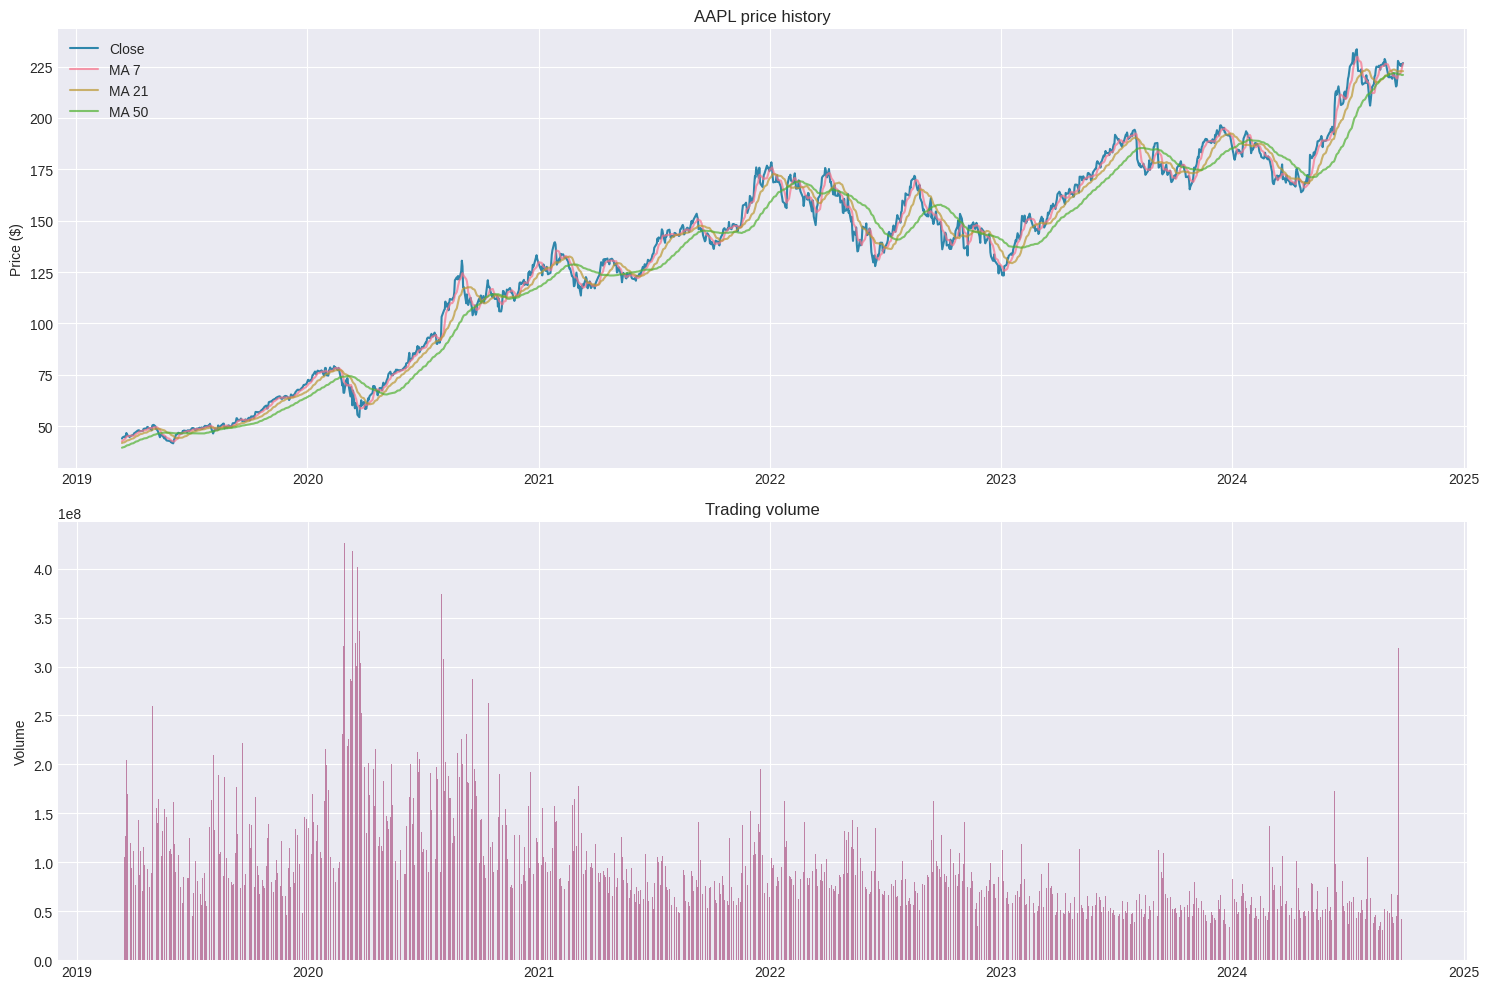

Saved technical indicators chart


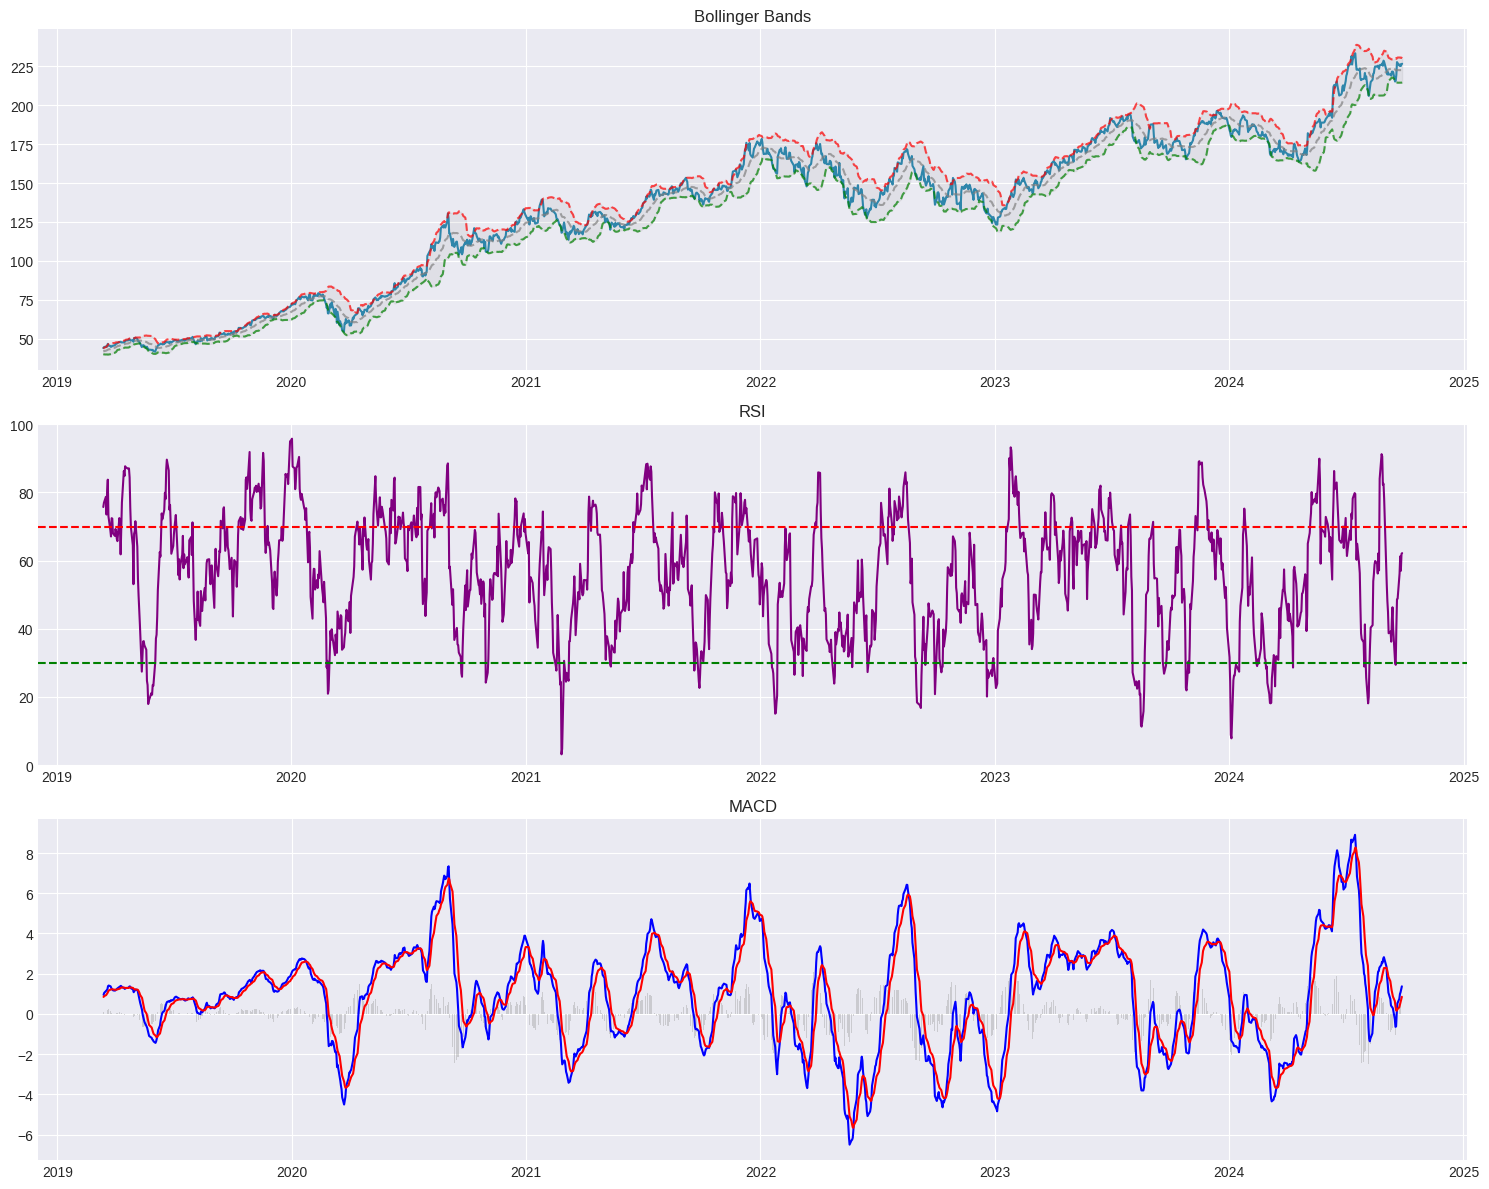

In [ ]:
predictor.plot_stock_history()
predictor.plot_technical_indicators()


## 3. Train Models


In [ ]:
predictor.train_linear_regression()
predictor.train_random_forest()

if RUN_LSTM:
    try:
        predictor.train_lstm(lookback=45, epochs=15)
    except Exception as err:
        print("Skipping LSTM due to error:", err)
else:
    print("RUN_LSTM is False, skipping the deep learning model for now.")


Training Linear Regression...
Results for Linear Regression (test set):
  RMSE: 2.88
  MAE:  2.13
  R2:   0.9786
  MAPE: 1.11%
Done with Linear Regression
Training Random Forest...
Results for Random Forest (test set):
  RMSE: 17.40
  MAE:  10.75
  R2:   0.2164
  MAPE: 5.05%
Done with Random Forest
RUN_LSTM is False, skipping the deep learning model for now.


## 4. Evaluate and Compare


Saved predictions comparison chart


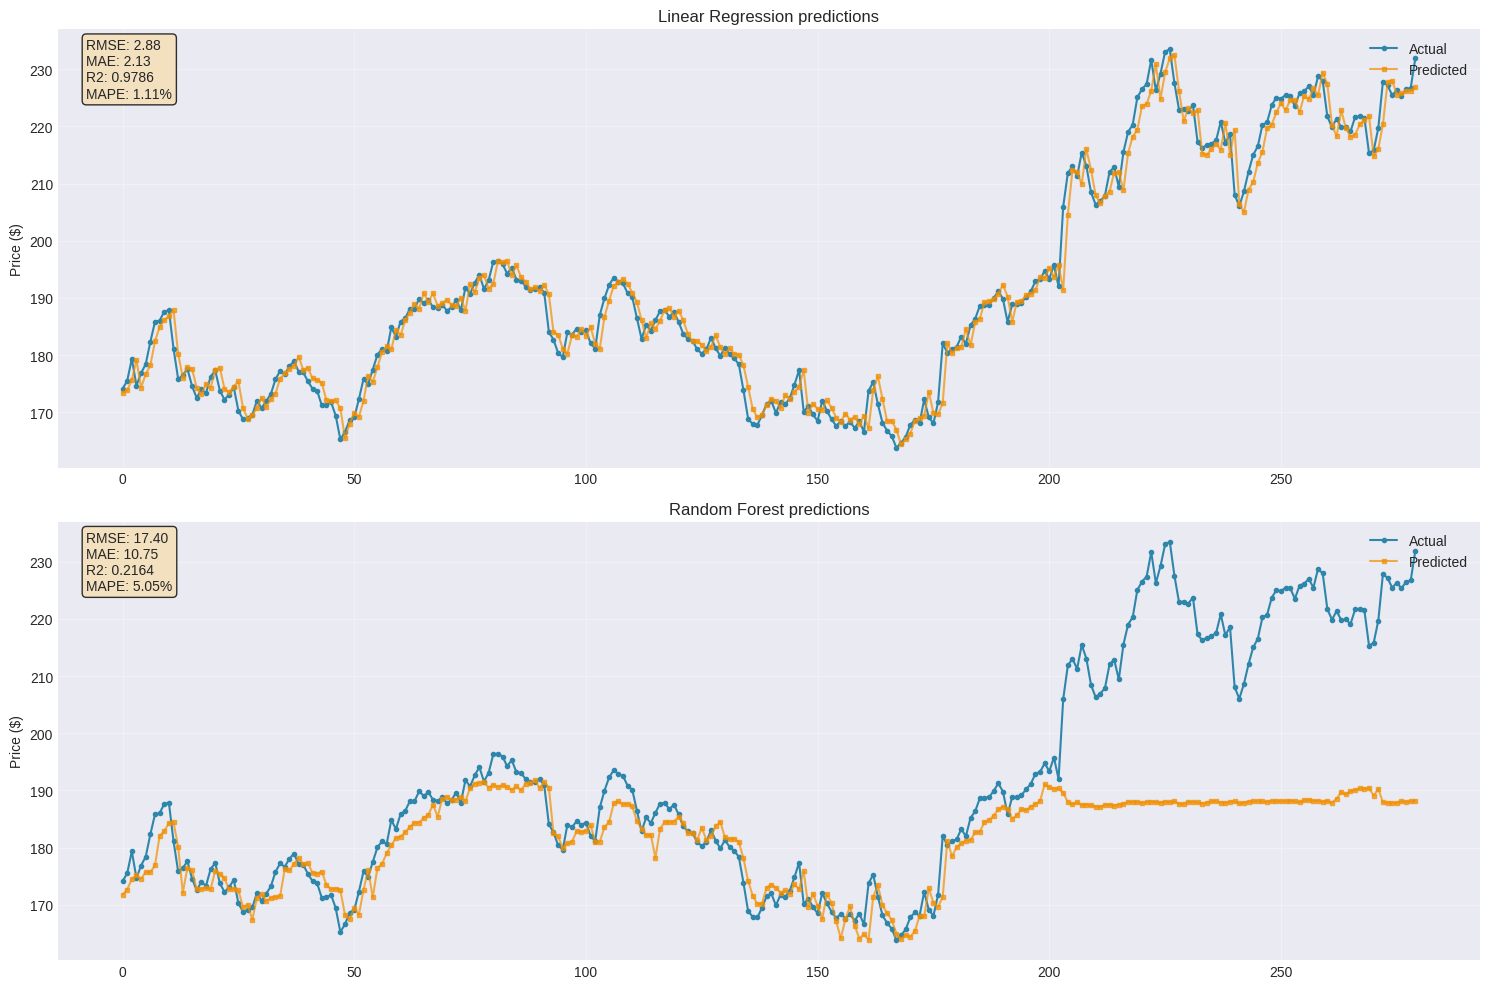

Saved metrics comparison chart


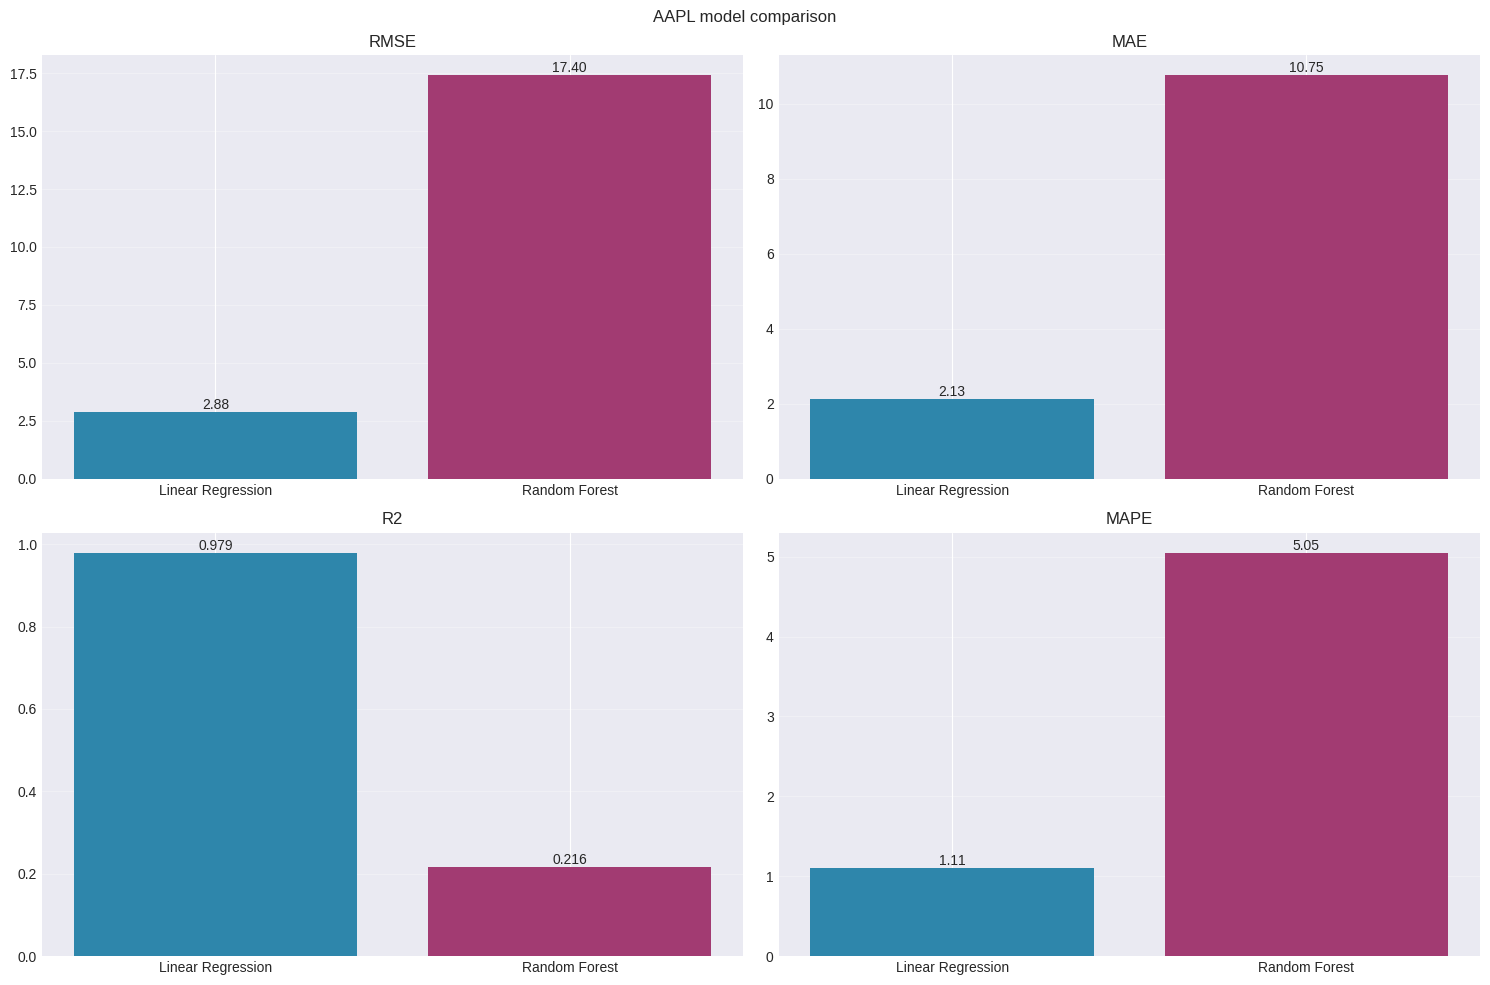


Directional accuracy summary:
Linear Regression directional accuracy: 52.1%
Predicted: ↑ ↑ ↑ ↑ ↓ ↑ ↑ ↑ ↑ ↑
Actual:    ↑ ↑ ↑ ↓ ↑ ↑ ↑ ↑ ↑ ↑
Random Forest directional accuracy: 56.4%
Predicted: ↓ ↑ ↑ ↑ ↓ ↑ ↓ ↑ ↑ ↑
Actual:    ↑ ↑ ↑ ↓ ↑ ↑ ↑ ↑ ↑ ↑


In [ ]:
predictor.plot_predictions()
predictor.plot_metrics_comparison()

print("\nDirectional accuracy summary:")
predictor.summarize_direction("Linear Regression")
predictor.summarize_direction("Random Forest")
if RUN_LSTM and "LSTM" in predictor.predictions:
    predictor.summarize_direction("LSTM")


## 5. Generate Final Report


In [ ]:
predictor.generate_report()



Final report for AAPL
Samples: 1396
Date range: 2019-03-14 to 2024-09-27

Test metrics:
Linear Regression
  RMSE: 2.88
  MAE:  2.13
  R2:   0.9786
  MAPE: 1.11%
Random Forest
  RMSE: 17.40
  MAE:  10.75
  R2:   0.2164
  MAPE: 5.05%

Best model (lowest RMSE): Linear Regression
Saved text report
